<a href="https://colab.research.google.com/github/mikelevvra/GeiloAlberti/blob/main/Alberti_Geilo_2025_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning for Inverse Problems**
**Geilo Winter school 2025**


Goals of the lesson:

Use the library  _deep inverse_ to
*   simulate a deblurring problem
*   implement variational regularization strategies
*   use a Plug-and-Play scheme with a pre-trained denoiser
*   use a Plug-and-Play scheme, training a denoiser
*   implement and train a deep unfolding reconstruction method

Luca Ratti, Università di Bologna, luca.ratti5@unibo.it

Reference for the library: https://deepinv.github.io/deepinv/ by J. Tachella, D. Chen, S. Hurault, M. Terris and A Wang.

In [ ]:
%%capture
# Install deepinv (and ptwt, in case you need to use wavelets)
!pip install ptwt
!pip install git+https://github.com/deepinv/deepinv.git

In [ ]:
import deepinv as dinv
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from pathlib import Path
from torchvision import transforms, datasets
#from deepinv.models.utils import get_weights_url

from deepinv.optim.prior import Prior, PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.training import test
from deepinv.models import DRUNet
from deepinv.optim.dpir import get_DPIR_params
from deepinv.models import DnCNN

# Set the global random seed from pytorch to ensure reproducibility of the example.
torch.manual_seed(42)

# Specify the device (to use GPU on colab, first change the runtime to T4 GPU)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

# Use parallel dataloader if using a GPU to fasten training.
num_workers = 5 if torch.cuda.is_available() else 0

Selected GPU 0 with 15099 MiB free memory 


# **Create the physics: a deblurring + denoising problem**

Input: $a \in \mathbb{R}^{n \times n}(\cong \mathbb{R}^{n^2})\quad$  -  $\quad$ Output: $ b \in \mathbb{R}^{n \times n}(\cong \mathbb{R}^{n^2})$

Forward operator: convolution with a kernel (Point Spread Function) $k \in \mathbb{R}^{(2\nu+1)\times(2\nu+1)}$
$$ Fa = k * a, \qquad [Fa]_{i,j} = \sum_{p=-\nu}^\nu \sum_{q=-\nu}^\nu k_{p,q} a_{i-p,j-q}$$
(boundary conditions should be imposed on how to extend $a$ for indices $i,j$ before $1$ and after $n$)

Inverse problem: recover $a^+$ from $b = Fa^+ +\epsilon$, being $\epsilon \in \mathbb{R}^{n \times n}$ a random realization of Gaussian noise
$$ [\epsilon]_{i,j} \quad i.\!i.\!d. \sim \mathcal{N}(0,\delta^2)$$

In [ ]:
# Define the physics

# Blur: use a Gaussian filter k
#filter_0 = dinv.physics.blur.gaussian_blur(sigma=1).to(device=device) # vanilla filter: Gaussian of variance sigma Id
filter_0 = dinv.physics.blur.gaussian_blur(sigma=(1, 1), angle=0).to(device=device) # Gaussian with anisotropic variance, tilted of 45 degrees
# this filter simulates motion blur with a diagonal direction

# Noise model: additive gaussian
noise_level = 0.1  # delta
noise_model = dinv.physics.GaussianNoise(sigma=noise_level)

physics = dinv.physics.Blur(filter_0,padding='reflect',device=device,noise_model=noise_model)
# padding = 'reflect' specifies reflecting boundary conditions, avoiding jumps due to zero paddings

# **Create a dataset**

We start by importing the MNIST dataset of 28x28 images.

We then create a supervised dataset for the deblurring problem by constructing
$$ \{(b_i,a_i)\}_{i=1}^N, \qquad a_i \text{: an image from MNIST,}\quad b_i = Fa_i +\epsilon_i $$

Disclaimer: we use a rather small sample size $N$ to guarantee reasonable training times.

In [ ]:
%%capture
# Import the dataset
transform = transforms.Compose([transforms.ToTensor()])

Train_dataset = datasets.MNIST(root="../datasets/", train=True, transform=transform, download=True)
Test_dataset = datasets.MNIST(root="../datasets/", train=False, transform=transform, download=True)

# Create a supervised dataset of simulated measurements

# Specify the (maximum) size of the train and test sets
n_train_max = (250 if torch.cuda.is_available() else 50)  # number of images used for training
n_test_max = (50 if torch.cuda.is_available() else 10)  # number of images used for testing

# Set the path to save the datasets
BASE_DIR = Path(".")
measurement_dir = BASE_DIR / "dataset"

deepinv_datasets_path = dinv.datasets.generate_dataset(
    train_dataset=Train_dataset,
    test_dataset=Test_dataset,
    physics=physics,
    device=device,
    save_dir=measurement_dir,
    train_datapoints=n_train_max,
    test_datapoints=n_test_max,
    num_workers=num_workers,
    dataset_filename="deblur3"
)

train_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=True)
test_dataset = dinv.datasets.HDF5Dataset(path=deepinv_datasets_path, train=False)

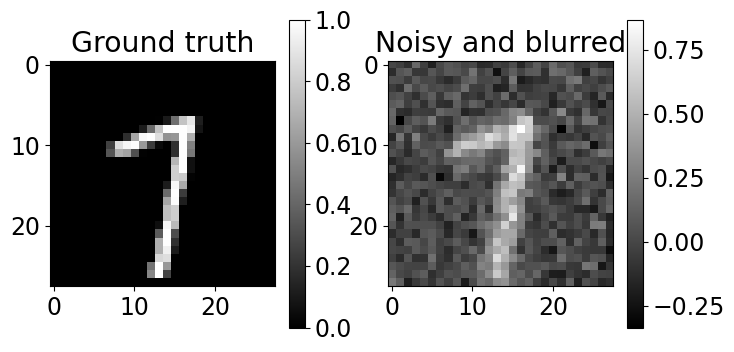

In [ ]:
# Vizualize images from the dataset

select_image = 42

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs0 = axs[0].imshow(train_dataset[select_image][0].squeeze(0), cmap='gray')
axs[0].set_title('Ground truth')
fig.colorbar(axs0)

axs1 = axs[1].imshow(train_dataset[select_image][1].squeeze(0), cmap='gray')
axs[1].set_title('Noisy and blurred')
fig.colorbar(axs1)


**********************************************************
**TASK 1**

Visualize the effect of a different blurring kernel $k$ and of a different noise level $\delta$.

Warning: when creating a new supervised dataset, always provide a new name to the variable 'dataset_filename'

**********************************************************

# **Variational regularization techniques**

Choose a regularization functional $R: \mathbb{R}^{n^2}\rightarrow \mathbb{R}$ and a parameter $\lambda >0 $ and solve
$$ a_\lambda = \arg\min_{a \in \mathbb{R}^{n^2}} \left\{ \frac{1}{2}\| Fa-b\|^2 + \lambda R(a)\right\}$$

Test:  98%|██████████████████████████████████████████████████████████████████████▌ | 49/50 [00:44<00:00,  1.25it/s, PSNR=20.4, PSNR no learning=-16.3]

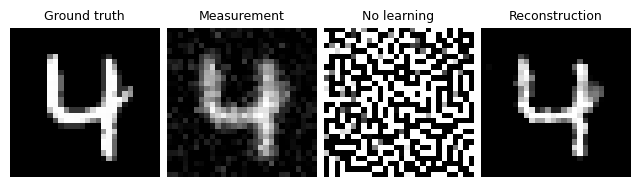

Test: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [00:44<00:00,  1.12it/s, PSNR=20.4, PSNR no learning=-16.3]

Test results:
PSNR no learning: -16.310 +- 0.427
PSNR: 20.384 +- 1.267


{'PSNR no learning': -16.30974328994751,
 'PSNR no learning_std': 0.42703365131102744,
 'PSNR': 20.383525199890137,
 'PSNR_std': 1.2668208222776498}

In [ ]:
# Select the data fidelity term (the first part of the functional to be minimized)
data_fidelity = dinv.optim.data_fidelity.L2()

# Specify the custom prior R, e.g. Tikhonov, L1Prior, TVPrior, WaveletPrior
prior = dinv.optim.prior.L1Prior()

# Specific parameters for restoration with the given prior (Note that these parameters have not been optimized here)
params_algo = {"stepsize": .05, "lambda": 0.08}

# Instantiate the algorithm class to solve the IP problem.
modelVAR = optim_builder(
    iteration="PGD", # proximal gradient descent
    prior=prior,
    g_first=False,
    data_fidelity=data_fidelity,
    params_algo=params_algo,
    early_stop=True,
    max_iter=500,
    crit_conv="cost",
    thres_conv=1e-5,
    backtracking=False,
    verbose=False,
)


# The model does not need any training.
# To get its 'average performances' we apply it to all the elements of the test set and take an average

batch_size = 1
var_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

test(
    model=modelVAR,
    test_dataloader=var_dataloader,
    physics=physics,
    device=device,
    verbose=True,
    plot_images = True,
)


# also observe the "No learning" results, which are the reconstruction given by the pseudoinverse

**********************************************************
**TASK 2**

Explore alternative choices for $R$. Good candidates are Total Variation, or sparsity promotion with respect to wavelets: $R(a) = \| W a \|_1$ being $W$ a wavelet transform. Have a look at https://deepinv.github.io/deepinv/api/stubs/deepinv.optim.Prior.html#deepinv.optim.Prior


**********************************************************